## Imports, constants, functions

In [1]:
import numpy as np

In [2]:
import matplotlib as mpl
from matplotlib import cm
from matplotlib import colorbar

mpl.rcParams['axes.linewidth'] = 1.0 #set the value globally
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import mdtraj as md

In [3]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
mma_color = 'tab:blue'
ea_color = 'tab:orange'
nba_color = 'tab:green'

In [7]:
temp = [ ] ## a list of temperatures. Provide the list from high to low temperature. 
# For PEA data uncomment the code below:
# temp = [ '600','550','500','450', '400', '350', '300', '250', '200', '150', '100'] 
#temp = np.arange(100, 650, 50)
#temp = temp[::-1]  # high to low temperature

In [6]:
#temp  #The temp range should be in high to low temperature order: this is will be used later for hyperbola fitting 

In [8]:
nstate = temp.shape[0]  ##number of temperatures to combine
nchain = 100    ## number of polymer chains in the simulation box
nframe = 101  ## number of frames. 10 ns simulation; every 100ps dump step. 
n_mono = 15  ## number of monomer in a polymer chain   

In [9]:
number_of_pc_dimensions = 3 # one can vary this number

In [10]:
def pca_mdtraj(pair_distance,frac_var=None):
    descriptor = pair_distance
    
    #standardize data (mean of each column goes to zero, i.e., variables are mean free)
    scaler = StandardScaler()
    scaler.fit(descriptor)
    descriptor=scaler.transform(descriptor)
    variance_input = scaler.var_
    #core PCA
    from sklearn.decomposition import PCA
    pca = PCA().fit(descriptor)
    pca_projection = PCA(n_components=frac_var).fit_transform(descriptor)
    
    return pca, pca_projection, variance_input

In [11]:
def avg_labels(labels_all):
    labels_all = np.array(labels_all)
    avg_label = np.mean(labels_all, axis =0) #Average over all the chains
    avg_label = np.reshape(avg_label,(nstate,nframe))  #reshape as nstate, nframe
    avg_label1 = np.mean(avg_label,axis = 1)  #average over all the frames
    return avg_label1

In [12]:
def curve_fitting(xax, yax,s0,d0):
    eps = 0.00001
    cdt = np.abs(yax[-1]-yax[0])
    #for fixed cdt
    popt, pcov = curve_fit(model_function, xax, yax, p0=[cdt,s0,d0],
                            bounds=((cdt-eps, -np.inf, -np.inf), (cdt+eps, np.inf, np.inf)))
    return popt

def model_function(xax, cdt, s, d):
    yax = cdt*(1.0-np.tanh(s*xax-d))/2.0 #Eq-3 of our paper
    return yax

def inflectpt(xinp, yinp,s0,d0):
    popt = curve_fitting(xinp, yinp,s0,d0)
    print('C='+str(popt[0]), 's='+str(popt[1]),'d='+str(popt[2]), "Tg_val(d/s) = "+str(popt[2]/popt[1]))
    xax = np.linspace(xinp[0], xinp[-1], 100, endpoint=True)
    yax = model_function(xax, *popt)
    return xax, yax, popt[1]

In [13]:
def lambda1(var_expl_ratio):
    p_ratio = []
    for i in range(var_expl_ratio.shape[0]):
        v0 = var_expl_ratio[i][0]
        v1 = 1
        p_ratio.append(v0/v1)

    p_ratio = np.array(p_ratio)
    p_ratio.shape
    nstate = int(p_ratio.shape[0]/nchain)
    p_ratio= p_ratio.reshape(nchain,nstate)
    p_ratio_mean = np.mean(p_ratio, axis =0)
    p_ratio_std = np.std(p_ratio, axis =0)
    return p_ratio_mean,p_ratio_std

In [14]:
def PR(var_expl_ratio):
    p_ratio = []
    for i in range(var_expl_ratio.shape[0]):
        v0= (np.sum(var_expl_ratio[i,:]))**2 # use classical decsription of PR
        v1= np.sum(var_expl_ratio[i,:]**2)
        p_ratio.append(v0/v1)

    p_ratio = np.array(p_ratio)
    p_ratio.shape
    p_ratio= p_ratio.reshape(nchain,nstate)
    p_ratio_mean = np.mean(p_ratio, axis =0)
    p_ratio_std = np.std(p_ratio, axis =0)
    return p_ratio_mean,p_ratio_std

# 1) Load the trajectory files for PEA systems

Please download the homopolymer data from the link https://doi.org/10.17617/3.4JHOMW



In [5]:
XTC_DIR = './xtc_files/' ## directory of the xtc files contains trajectory file at different temp and a topology file

In [20]:
traj_all_states = []
for i in temp:
    topfile = XTC_DIR+ 'pea.pdb'   #upload the topology file
    traj_file = XTC_DIR+ 'pea_temp'+str(i)+'K.xtc' #upload the .XTC file at each temperature
    traj= md.load(traj_file,top=topfile)
    traj = traj[::25]     #evergy 100ps 
    top = md.load(topfile).topology
    print(i, traj)
    traj_all_states.append(traj)

In [12]:
#USER INPUT --> for C5 and C7 carbons for pea (Fig1a blue beads)
# Select desired beads  --> this selection will vary with polymers

In [20]:
#use this cell if you're using the *.xtc files
atm_indx_c5 = top.select("name C5")
atm_indx_c7 = top.select("name C7")

# 2) Method I: Use the side chains and combine the temeprature

## 2.1) PCA projection of a single random chain

In [18]:
chain = 0 # a random chain, choose any index from 0 to 99

In [23]:
atm_side_chain = np.concatenate((atm_indx_c5[n_mono*chain:n_mono*(chain+1)],
                                atm_indx_c7[n_mono*chain:n_mono*(chain+1)]))
atom_pairs = top.select_pairs(atm_side_chain,atm_side_chain)
distance_all = []
for i in range(len(temp)):  # loading individual temperatures
    traj = traj_all_states[i]
    pair_distance = md.compute_distances(traj,atom_pairs,periodic=True, opt=True) # compute pairwise distances
    distance_all.append(pair_distance) 
distance_all = np.array(distance_all)
distance_all = np.concatenate(distance_all)  #concatinating all the temperatures

In [24]:
pca_on_single_chain = pca_mdtraj(distance_all)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

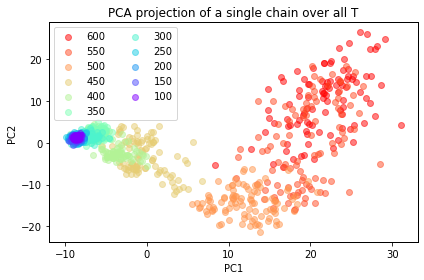

In [25]:
color = iter(cm.rainbow_r(np.linspace(0, 1,len(temp))))
for i in range(0,len(temp)):
    c = next(color)
    _ = plt.scatter(pca_on_single_chain[1][(i)*nframe:(i+1)*nframe,0],
                    pca_on_single_chain [1][(i)*nframe:(i+1)*nframe,1], c=c,  alpha = 0.5,label = temp[i])
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.legend(ncol = 2)
plt.title("PCA projection of a single chain over all T")
#plt.savefig('ea_pca_all.pdf')
plt.tight_layout()

## 2.2) Average over all the chains 

In [26]:
labels_all_ag = []
for chain in range(nchain): # Repeat over all chains
    print(' Method I: calculation started for chain index = '+ str(chain))
    atm_side_chain = np.concatenate((atm_indx_c5[n_mono*chain:n_mono*(chain+1)],
                                    atm_indx_c7[n_mono*chain:n_mono*(chain+1)]))
    atom_pairs = top.select_pairs(atm_side_chain,atm_side_chain)
    distance_all = []
    for i in range(len(temp)):
        traj = traj_all_states[i]
        pair_distance = md.compute_distances(traj,atom_pairs,periodic=True, opt=True)
        distance_all.append(pair_distance)
        
    distance_all = np.array(distance_all)
    distance_all = np.concatenate(distance_all)
    pca_on_single_chain = pca_mdtraj(distance_all)
    
    X = StandardScaler().fit_transform(pca_on_single_chain[1][:,0:number_of_pc_dimensions])
    clustering = AgglomerativeClustering().fit(X)  #use the scaled data for clustering
    labels = clustering.labels_
    if labels[-1] == 0:   #cheking the lowest temperature label
        labels = labels
    else:
        where_0 = np.where(labels == 0)
        where_1 = np.where(labels == 1)

        labels[where_0] = 1
        labels[where_1] = 0
    labels_all_ag.append(labels)
labels_all_ag = np.array(labels_all_ag)

 Method I: calculation started for chain index = 0
 Method I: calculation started for chain index = 1
 Method I: calculation started for chain index = 2
 Method I: calculation started for chain index = 3
 Method I: calculation started for chain index = 4
 Method I: calculation started for chain index = 5
 Method I: calculation started for chain index = 6
 Method I: calculation started for chain index = 7
 Method I: calculation started for chain index = 8
 Method I: calculation started for chain index = 9
 Method I: calculation started for chain index = 10
 Method I: calculation started for chain index = 11
 Method I: calculation started for chain index = 12
 Method I: calculation started for chain index = 13
 Method I: calculation started for chain index = 14
 Method I: calculation started for chain index = 15
 Method I: calculation started for chain index = 16
 Method I: calculation started for chain index = 17
 Method I: calculation started for chain index = 18
 Method I: calculation

In [27]:
labels_all_ag_system = avg_labels(labels_all_ag)

In [28]:
labels_all_ag_system

array([9.44455446e-01, 9.55445545e-01, 9.23267327e-01, 4.77920792e-01,
       1.43069307e-01, 2.94059406e-02, 9.90099010e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

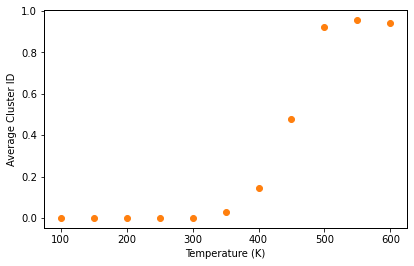

In [44]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6.5,4.0))
plt.plot(temp,labels_all_ag_system,'o',color=ea_color)
axs.set_xlabel(r'Temperature (K)',size=10)
axs.set_ylabel('Average Cluster ID',size=10)
plt.show()

## 2.3) Calculation of $T_g$ from Method I

  Fitting function (Eq. 3 of the manuscript):
   $$g(T)=C(1-\tanh(sT-d))/2$$


In [30]:
xval = temp # temperature list
labels_all_ag_system = avg_labels(labels_all_ag)
yval = labels_all_ag_system
fitting_out = inflectpt(xval, yval, 1/50, 50/400) #last two are initial guess value: 1/(gap_between_two_temp), gap/jump

#print(fitting_out[2]/fitting_out[1])

C=0.9444654455445542 s=-0.022737673965980032 d=-10.148617267943722 Tg_val(d/s) = 446.33489261601784


In [31]:
xval

array([600, 550, 500, 450, 400, 350, 300, 250, 200, 150, 100])

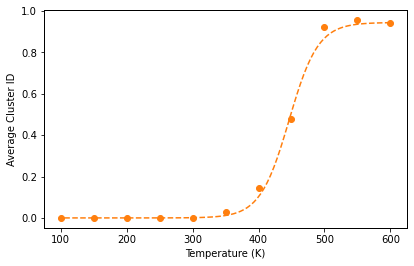

In [43]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6.5,4.0))
axs.plot(fitting_out[0], fitting_out[1], '--', label = 'Fitting', color = ea_color)
axs.plot(temp,labels_all_ag_system,'o',color=ea_color)

axs.set_xlabel(r'Temperature (K)',size=10)
axs.set_ylabel('Average Cluster ID',size=10)
plt.show()

# 3) Method II: Use side chains and perform PCA on the individual temepratures

## 3.1) PCA projection of a sinle random chain  for individual T

In [33]:
chain = 0 # a random chain, choose any index from 0 to 99

Use this cell if you are loading the *.xtc files; otherwise use the next cell to load the distance files directly

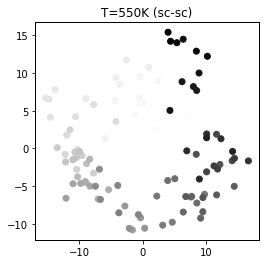

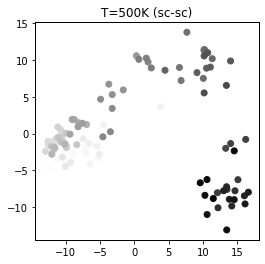

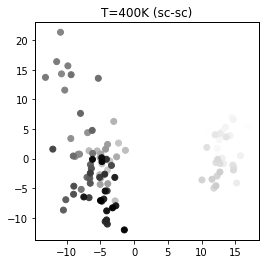

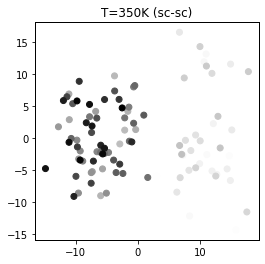

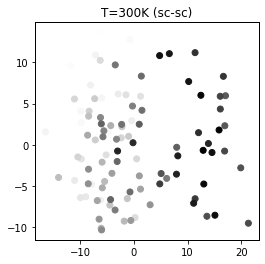

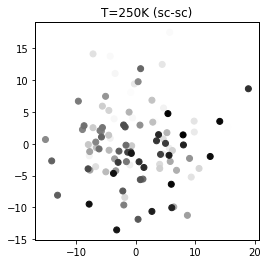

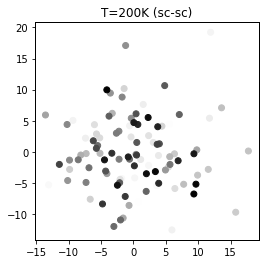

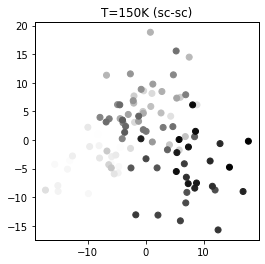

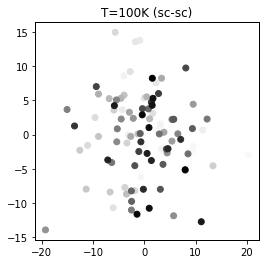

In [34]:
atm_side_chain = np.concatenate((atm_indx_c5[n_mono*chain:n_mono*(chain+1)],
                                 atm_indx_c7[n_mono*chain:n_mono*(chain+1)]))
atom_pairs = top.select_pairs(atm_side_chain,atm_side_chain)
indx =0 
for i in range(len(temp)):
    plt.figure(figsize=(4,4))
    traj = traj_all_states[i]
    pair_distance = md.compute_distances(traj,atom_pairs,periodic=True, opt=True)

    pca_on_single_chain = pca_mdtraj(pair_distance)
    color = np.linspace(0, 1, 101)
    plt.scatter(pca_on_single_chain[1][:,0],pca_on_single_chain[1][:,1],c=color, cmap="Greys")
    plt.title("T="+str(temp[i])+'K (sc-sc)')

## 3.2) PCA on all chains and calculation of the average eigenvalue and participation ratio

In [35]:
var_expl_ratio = []
for chain in range(nchain): 
    print(' Method II: calculation started for chain index = '+ str(chain))
    atm_side_chain = np.concatenate((atm_indx_c5[n_mono*chain:n_mono*(chain+1)],
                                     atm_indx_c7[n_mono*chain:n_mono*(chain+1)]))
    atom_pairs = top.select_pairs(atm_side_chain,atm_side_chain)
    for i in range(len(temp)):
        traj = traj_all_states[i]
        pair_distance = md.compute_distances(traj,atom_pairs,periodic=True, opt=True)
        pca_on_single_chain = pca_mdtraj(pair_distance)
        var = pca_on_single_chain[0].explained_variance_ratio_
        var_expl_ratio.append(var)
var_expl_ratio = np.array(var_expl_ratio)


 Method II: calculation started for chain index = 0
 Method II: calculation started for chain index = 1
 Method II: calculation started for chain index = 2
 Method II: calculation started for chain index = 3
 Method II: calculation started for chain index = 4
 Method II: calculation started for chain index = 5
 Method II: calculation started for chain index = 6
 Method II: calculation started for chain index = 7
 Method II: calculation started for chain index = 8
 Method II: calculation started for chain index = 9
 Method II: calculation started for chain index = 10
 Method II: calculation started for chain index = 11
 Method II: calculation started for chain index = 12
 Method II: calculation started for chain index = 13
 Method II: calculation started for chain index = 14
 Method II: calculation started for chain index = 15
 Method II: calculation started for chain index = 16
 Method II: calculation started for chain index = 17
 Method II: calculation started for chain index = 18
 Me

#### Calculating average first eigenvalues as a function of temperature

In [36]:
first_eg = lambda1(var_expl_ratio)

No handles with labels found to put in legend.


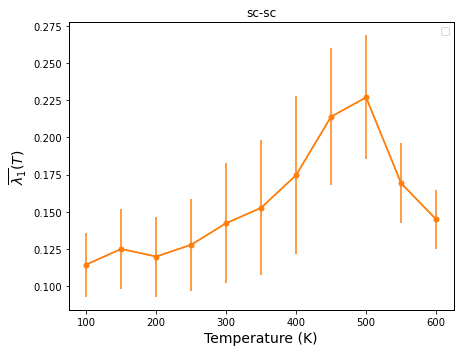

In [41]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6.5,5))

_ = axs.plot(temp,first_eg[0], 'o',linestyle= '-', ms=5,c= ea_color)
axs.errorbar(temp, first_eg[0] , yerr=first_eg[1], c= ea_color)

axs.xaxis.set_major_locator(plt.MaxNLocator(6))
axs.set_ylabel('$\overline{\lambda_1}(T)$',size=14)
axs.set_xlabel(r'Temperature (K)',size=14)
axs.legend()
axs.set_title('sc-sc')
plt.tight_layout()

#### Calculating average participation ratio (PR) as a function of temperature

In [38]:
participation_ratio = PR(var_expl_ratio)

No handles with labels found to put in legend.


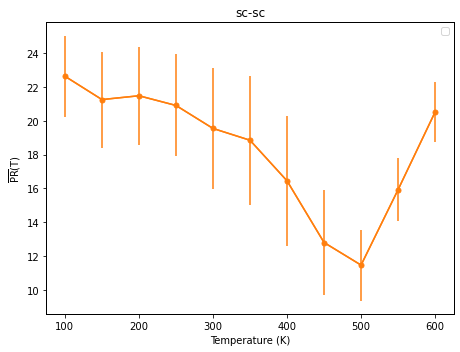

In [40]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6.5,5))

_ = axs.plot(temp,participation_ratio[0], 'o',linestyle= '-', ms=5,c= ea_color)
axs.errorbar(temp,participation_ratio[0] , yerr=participation_ratio[1], c= ea_color)

axs.xaxis.set_major_locator(plt.MaxNLocator(6))
axs.set_ylabel(r'$\overline{\rm PR}(T)$',size=10)
axs.set_xlabel(r'Temperature (K)',size=10)
axs.legend()
axs.set_title('sc-sc')
plt.tight_layout()